## Generating samples from Tweedie distibution 
Tweedie distribution is used for modeling nonnegative random variables with a nonzero mass at zero. One of the typical applications of it is modeling insurance claims, where the number of claims is modeled by a Poisson and the claim severity by a gamma random variable. This notebook is a simple exercise of generating samples from the Tweedie distribution.  The output will be compared with the samples generated with the R `tweedie` package. 

In [1]:
suppressWarnings({
    library(tweedie)
    library(ggplot2)
    library(repr)
})

### Parameter correspondence between Poisson - Gamma compound and Tweedie
Continuing with the insurance claims example, for a given policy, the number of claims $T$ is a  nonnegative number, modeled by a Poisson random variable.  Then each claim has a claim amount (i.e. *severity*) modeled by a Gamma random variable.  The total claim amount is the sum of $T$ independent Gamma variables.  
Claim count: $\text{Poisson}(\lambda)$  
Severity of each claim: $\text{Gamma}(\alpha, \theta)$  
Total claim amount: $\text{Tweedie}(p, \mu, \phi)$

These paremeters have the following relationship (*)


$$ p = \frac{(\alpha + 2)}{(\alpha + 1)}, \\  \mu = \lambda \cdot \alpha \cdot \theta ,\\ \phi = \frac{\lambda^{1-p}\cdot (\alpha \cdot \theta)^{2-p}}{2-p}.$$

(*) [Myers, G, Predictive Modeling with the Tweedie Distribution](https://www.casact.org/education/annual/2009/handouts/c25-meyers.pdf)


In [2]:
poisson_gamma_to_tweedie <- function(lambda, alpha, theta) {
    # Translates the parameters of Poisson and gamma distributions into that of a Tweedie distribution
    p <- (alpha+2)/(alpha+1)
    mu <- lambda*alpha*theta
    phi <- (lambda^(1-p))*((alpha*theta)^(2-p))/(2-p)
    return(list(p=p, mu=mu, phi=phi))
}

The following function generates samples form the Poisson-Gamma compound:

In [3]:
rpoisgam <- function(N, lambda, alpha, theta) {
    sample <- rep(0,N)
    pois <- rpois(N, lambda)
    for (i in 1:N) {
        if (pois[i]>0 ) {
            T <- pois[i]
            sample[i] <- sample[i] + sum(rgamma(T, shape=alpha, scale=theta))         
        }
    }
    return(sample)
}

In [4]:
lambda <- 0.8
alpha <- 2
theta <- 5
tweedie_params <- poisson_gamma_to_tweedie(lambda, alpha, theta)

In [5]:
tweedie_sample <- rtweedie( 10000, xi=tweedie_params$p, 
                            mu=tweedie_params$mu, 
                            phi=tweedie_params$phi)

In [6]:
poisson_gamma_sample <- rpoisgam(10000, lambda, alpha, theta)

In [7]:
df1 <- data.frame(y=tweedie_sample, generator = 'tweedie')
df2 <- data.frame(y=poisson_gamma_sample, generator = 'poisson_gamma')
df <- rbind(df1, df2)
df$generator <- as.factor(df$generator)
rm(list = c('df1', 'df2'))

Now we compare the densities of samples generated by two different ways using `ggplot`:

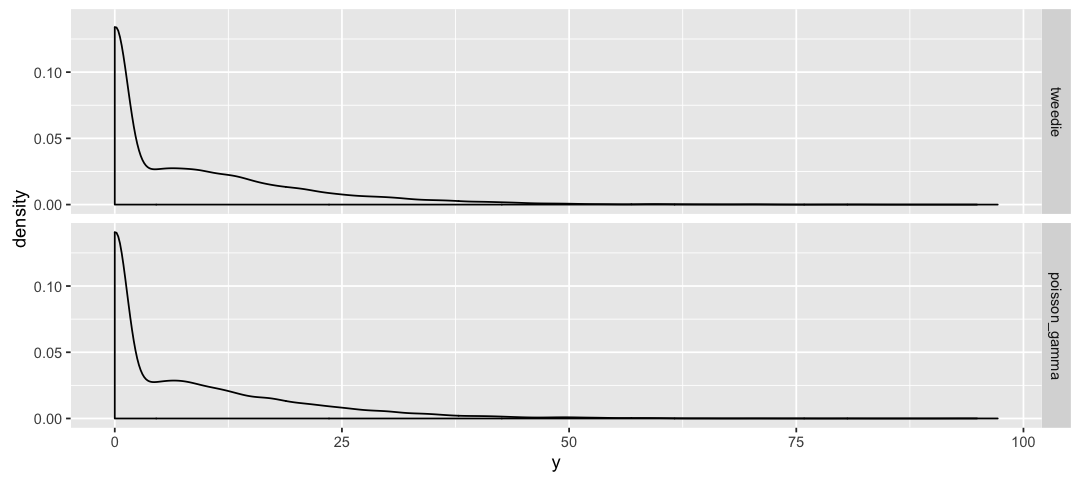

In [8]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(df, aes(y)) + facet_grid(generator ~ .) + geom_density(alpha=0.1)